# 합성곱 신경망

### 1. 라이브러리 설치

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.0.1+cpu


### 2. 데이터 로드 및 하이퍼 파라미터 지정

In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 첫번째 인자 root는 데이터를 저장할 위치(여기서는 현재 코드가 있는 위치), train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미합니다.
# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어져 있습니다. 
# transform은 이미지에 대한 변형, target_transform은 정답 라벨에 대한 변형을 의미합니다.
# transform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿔줍니다.

# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
mnist_train = dset.MNIST(root="../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))
print(mnist_train[0])

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

### 3. DataLoader 설정

In [ ]:
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last= True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last= True)

# num_workers = 사용할 프로세스 개수
# drop_last = 남는 데이터 처리 여부

### 4. 모델, 손실/최적화 함수

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer =nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self,x):
        out = self.layer(x)             # self.layer에 정의한 Sequential의 연산을 차례대로 실행
        out = out.view(batch_size, -1)  # view 함수를 이용해 텐서의 형태를 [batch_size, 나머지]로 변환
        out = self.fc_layer(out)        # ex) 2*3 형태의 텐서를 .view(1,-1) 해주면 1*6의 형태로 변경, .view(3,-1)이면 3*2로 바뀜
        return out                      # 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류가 발생


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

cpu


### 5. 학습

In [ ]:
from tqdm import tqdm

loss_arr = []

for i in tqdm(range(num_epoch)):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        
        loss_arr.append(loss.cpu().detach().numpy())

100%|██████████| 10/10 [04:16<00:00, 25.70s/it]


### 6. 학습시 손실 시각화

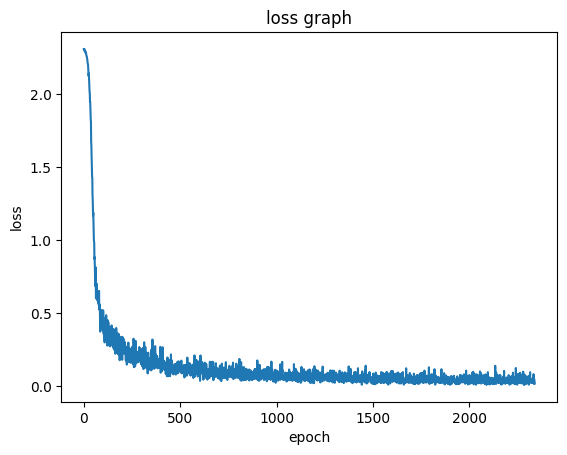

In [ ]:
plt.plot(loss_arr)
plt.title('loss graph')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 7. 테스트 데이터 정확도 측정

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y = label.to(device)
        
        output = model.forward(x)             # 모델에 데이터를 넣고 결과값 도출
        _, output_index = torch.max(output,1) # torch.max를 사용해 max value, index 도출. 여기서는 index만 사용
        
        total += label.size(0)                       # batch_size, drop_last로 데이터의 총 개수가 달라질 수 있어 새로 더함. label size의 0번째 인덱스 값은 batch_size에 해당
        correct += (output_index == y).sum().float() # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
    
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.72796630859375%
